# **Creation of a LSTM Model to predict Bitcoin Stocks using Time Series**


In [ ]:
#Import libraries to be used

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler


In [ ]:
#Read imported csv file with all the Bitcoin data and creation of a dataframe

#This project was initially created in Google Colab, if you are trying to run the code in another path, change the file_csv value with the correct path

file_csv = 'sample_data/bitcoin.csv'
df_bitcoin = pd.read_csv(file_csv)
#df_bitcoin = pd.read_csv(file_csv,index_col='Open time')


Since we are going to be working with a Time Series, we must:


1.   Be sure that at least one column is of Datetime type, if not, we need to convert it
2.   Save the Datetime column as the Index of the Dataframe



In [ ]:
#Print some of the features of the dataframe

print(df_bitcoin.shape)
print(df_bitcoin.columns)
print(df_bitcoin.dtypes)
print(df_bitcoin.head())
#print(df_bitcoin.tail())

(234001, 12)
Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')
Open time                        object
Open                            float64
High                            float64
Low                             float64
Close                           float64
Volume                          float64
Close time                       object
Quote asset volume              float64
Number of trades                  int64
Taker buy base asset volume     float64
Taker buy quote asset volume    float64
Ignore                            int64
dtype: object
             Open time      Open      High       Low     Close      Volume  \
0  2018-01-01 00:00:00  13715.65  13715.65  13400.01  13556.15  123.616013   
1  2018-01-01 00:15:00  13533.75  13550.87  13402.00  13521.12   98.136430   
2  2018-01-01 00:30:00  13500.0

In [ ]:
#We can see the 'Open time' column is object type, so we need to convert to datatime

df_bitcoin['Open time'] = pd.to_datetime(df_bitcoin['Open time'])
print(df_bitcoin.dtypes)

Open time                       datetime64[ns]
Open                                   float64
High                                   float64
Low                                    float64
Close                                  float64
Volume                                 float64
Close time                              object
Quote asset volume                     float64
Number of trades                         int64
Taker buy base asset volume            float64
Taker buy quote asset volume           float64
Ignore                                   int64
dtype: object


In [ ]:
#Now we can save the 'Open time' column as the index of the dataframe
df_bitcoin = df_bitcoin.set_index('Open time')

#Order the dataframe in ascending order considering the 'Datetime'
df_bitcoin.sort_index(inplace=True)

print(df_bitcoin.head())

                         Open      High       Low     Close      Volume  \
Open time                                                                 
2018-01-01 00:00:00  13715.65  13715.65  13400.01  13556.15  123.616013   
2018-01-01 00:15:00  13533.75  13550.87  13402.00  13521.12   98.136430   
2018-01-01 00:30:00  13500.00  13545.37  13450.00  13470.41   79.904037   
2018-01-01 00:45:00  13494.65  13690.87  13450.00  13529.01  141.699719   
2018-01-01 01:00:00  13528.99  13571.74  13402.28  13445.63   72.537533   

                                  Close time  Quote asset volume  \
Open time                                                          
2018-01-01 00:00:00  2018-01-01 00:14:59.999        1.675545e+06   
2018-01-01 00:15:00  2018-01-01 00:29:59.999        1.321757e+06   
2018-01-01 00:30:00  2018-01-01 00:44:59.999        1.078825e+06   
2018-01-01 00:45:00  2018-01-01 00:59:59.999        1.917783e+06   
2018-01-01 01:00:00  2018-01-01 01:14:59.999        9.778198e+05  

In [ ]:
#Print some of the features of the dataframe

print(df_bitcoin.shape)
print(df_bitcoin.columns)
print(df_bitcoin.head())
print(df_bitcoin.dtypes)

(234001, 11)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')
                         Open      High       Low     Close      Volume  \
Open time                                                                 
2018-01-01 00:00:00  13715.65  13715.65  13400.01  13556.15  123.616013   
2018-01-01 00:15:00  13533.75  13550.87  13402.00  13521.12   98.136430   
2018-01-01 00:30:00  13500.00  13545.37  13450.00  13470.41   79.904037   
2018-01-01 00:45:00  13494.65  13690.87  13450.00  13529.01  141.699719   
2018-01-01 01:00:00  13528.99  13571.74  13402.28  13445.63   72.537533   

                                  Close time  Quote asset volume  \
Open time                                                          
2018-01-01 00:00:00  2018-01-01 00:14:59.999        1.675545e+06   
2018-01-01 00:15:00  2018-01-01 00:29:59.9

We can see that the dataframe has values for samples every 15 minutes.

Since we want to make the analysis per day, we are going to create a new dataframe using slicing notation to save one value each 96 samples

We have 4 samples of 15 minutes in one hour and day has 24 of hours, then
4*24=96. This is the period required to extract one value per day in the dataframe.

In [ ]:
df_hour = df_bitcoin.iloc[::4]
df_day= df_bitcoin.iloc[::96]

print(df_day.head())

#Check if we have unique values for the 'Datetime' (no days repeated)
print(df_day.index.is_unique)

                         Open      High       Low     Close      Volume  \
Open time                                                                 
2018-01-01 00:00:00  13715.65  13715.65  13400.01  13556.15  123.616013   
2018-01-02 00:00:00  13382.16  13539.54  13382.16  13490.42   91.126953   
2018-01-03 00:00:00  14690.00  14773.00  14675.11  14750.01  126.449936   
2018-01-04 00:00:00  14919.51  14948.00  14750.00  14810.25  194.505609   
2018-01-05 01:45:00  15074.99  15098.15  15000.00  15040.00  222.570978   

                                  Close time  Quote asset volume  \
Open time                                                          
2018-01-01 00:00:00  2018-01-01 00:14:59.999        1.675545e+06   
2018-01-02 00:00:00  2018-01-02 00:14:59.999        1.228446e+06   
2018-01-03 00:00:00  2018-01-03 00:14:59.999        1.862855e+06   
2018-01-04 00:00:00  2018-01-04 00:14:59.999        2.886398e+06   
2018-01-05 01:45:00  2018-01-05 01:59:59.999        3.348956e+06  

We decided to take the 'Open' column as the one to be analyzed and predicted.

We are going to train the model with the data from 2018-2023 and the test will be done with the data from 2024 to the end.

We proceed to graph the data to view the Time Series.

We divide the graph in two sections to indentify the data to be use for the training and the one for the testing.

<Figure size 1000x600 with 0 Axes>

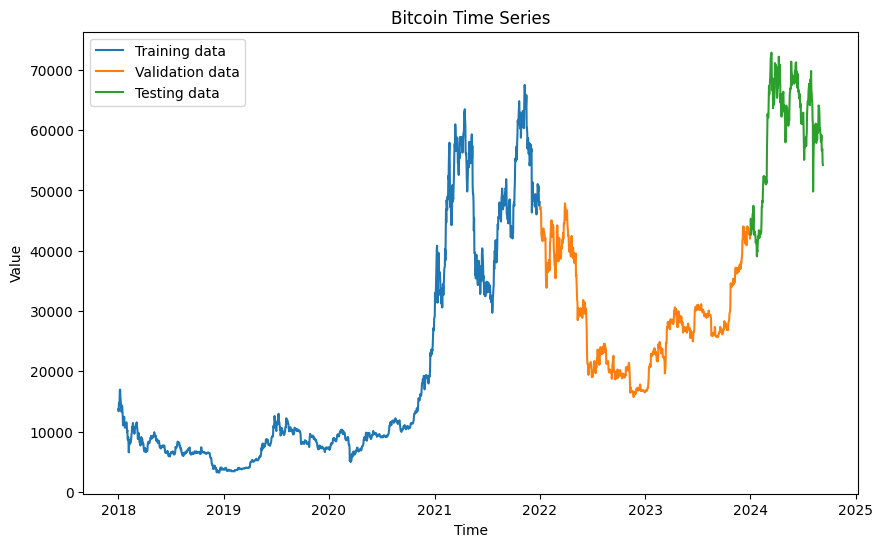

In [60]:
#Create the figure
plt.figure(figsize=(10, 6))

#Filter the Dataframe for different intervals
df_training = df_day[:'2021']
df_validation = df_day['2022':'2023']
df_testing = df_day['2024':]

#Graph the data filtered
plt.figure(figsize=(10, 6))
plt.plot(df_training['Open'], label = 'Training data')
plt.plot(df_validation['Open'], label = 'Validation data')
plt.plot(df_testing['Open'], label = 'Testing data')

#Customize the graph
plt.title('Bitcoin Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

#Show the figure
plt.show()

In [ ]:
#Check the shapes of the dataframes

print(df_day.shape)
print(df_training.shape)
print(df_testing.shape)

(2438, 11)
(2186, 11)
(252, 11)


In [61]:
#Since we are going to be using only one column for the analysis 'Open', we delete the other columns to optimize the use of the dataframe
keep_columns = ['Open']
df_reduced = df_day[keep_columns]

#Verify we only have one column
print(df_reduced.shape)

(2438, 1)


In [72]:
#Definition of the sets for training and testing
set_training = df_reduced[:'2021']
set_validation = df_reduced['2022':'2023']
set_testing = df_reduced['2024':]

print(set_training.shape)
print(set_validation.shape)
print(set_testing.shape)

(1456, 1)
(730, 1)
(252, 1)


We NORMALIZE the data in the range of 0-1 to improve the performance and the accuracy of the model, avoiding possible biases and a bad interpretation of the data.

In [73]:
#Check min/max values of the original sets
print(max(set_training.values))
print(min(set_training.values))
print(max(set_validation.values))
print(min(set_validation.values))
print(max(set_testing.values))
print(min(set_testing.values))


#Normalization and creation of sets scaled
sc = MinMaxScaler(feature_range=(0,1))
set_training_scaled = sc.fit_transform(set_training)
set_validation_scaled = sc.fit_transform(set_validation)
set_testing_scaled = sc.fit_transform(set_testing)

#Check min/max values of the scaled sets
print(max(set_training_scaled))
print(min(set_training_scaled))
print(max(set_validation_scaled))
print(min(set_validation_scaled))
print(max(set_testing_scaled))
print(min(set_testing_scaled))

#Check we keep the same shape
print(set_training_scaled.shape)
print(set_validation_scaled.shape)
print(set_testing_scaled.shape)

[67495.36]
[3185.04]
[47870.96]
[15732.37]
[72829.94]
[39065.68]
[1.]
[0.]
[1.]
[0.]
[1.]
[0.]
(1456, 1)
(730, 1)
(252, 1)


We are going to separate the total training set into arrays of 60 samples, which are the ones that we are going to use to train the model.

We are going to take 60 values and the 60 + 1 will be the target value to be estimated.

We are going to save different arrays of 60 elements and we will shift one place to the right to save another 60 samples with their respective target until we reach the end of the set

In [74]:
time_step = 60
X_train = []
Y_train = []

#Loop to add to X_train lists of 60 values and lists of 1 value to Y_train
for i in range(time_step,len(set_training_scaled)):
    X_train.append(set_training_scaled[i-time_step:i,0])
    Y_train.append(set_training_scaled[i,0])

#Convert the lists to np arrays
X_train, Y_train = np.array(X_train), np.array(Y_train)

#Reshape X_train to the form (samples,60,1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
#print(X_train)


(1396, 60, 1)


In [75]:
time_step = 60
X_validation = []
Y_validation = []

#Loop to add to X_validation lists of 60 values and lists of 1 value to Y_validation
for i in range(time_step,len(set_validation_scaled)):
    X_validation.append(set_validation_scaled[i-time_step:i,0])
    Y_validation.append(set_validation_scaled[i,0])

#Convert the lists to np arrays
X_validation, Y_validation = np.array(X_validation), np.array(Y_validation)

#Reshape X_validation to the form (samples,60,1)
X_validation = np.reshape(X_validation, (X_validation.shape[0],X_validation.shape[1],1))
print(X_validation.shape)

(670, 60, 1)


In [77]:
time_step = 60
X_test = []
Y_test = []

#Loop to add to X_test lists of 60 values and lists of 1 value to Y_test
for i in range(time_step,len(set_testing)):
    X_test.append(set_testing_scaled[i-time_step:i,0])
    Y_test.append(set_testing_scaled[i,0])

#Convert the lists to np arrays
X_test, Y_test = np.array(X_test), np.array(Y_test)

#Reshape X_train to the form (samples,60,1)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(192, 60, 1)


Creation of the LSTM model

In [78]:
#Input form: (samples,60,1)
inputs = Input(shape=(X_train.shape[1], 1))

#Number of neurons for the LSTM layer
na=50

lstm_layer = LSTM(na, return_sequences=False)(inputs)

dense_hidden1 = Dense(64, activation='relu')(lstm_layer)
dense_hidden2 = Dense(32, activation='relu')(dense_hidden1)
dense_hidden3 = Dense(16, activation='relu')(dense_hidden2)
output = Dense(1)(dense_hidden2)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')


In [79]:
#Train of the model including validation data
history = model.fit(X_train,Y_train,epochs=20,batch_size=32,validation_data=(X_validation, Y_validation))

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0792 - val_loss: 0.0031
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.8665e-04 - val_loss: 0.0019
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.3259e-04 - val_loss: 0.0017
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.9294e-04 - val_loss: 0.0016
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 6.5552e-04 - val_loss: 0.0015
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.1644e-04 - val_loss: 0.0014
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 4.6759e-04 - val_loss: 0.0013
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 5.4808e-04 - val_loss: 0.0014
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 5.0396e-04 - val_loss: 0.0014
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.8790e-04 - val_loss: 0.0011
Epoch 12/20
44/44 ━━━━━━━━━

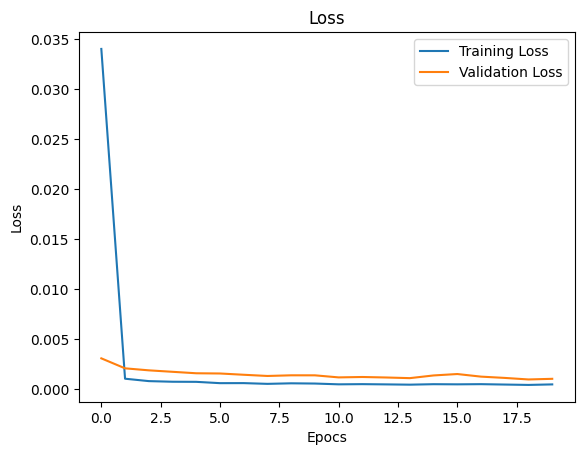

In [80]:
#Graph the Loss for training and validation to see if we have Overfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epocs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [96]:
#Prediction
prediction = model.predict(X_test)

#Transform the values from 0-1 range to original values
prediction = sc.inverse_transform(prediction)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [86]:
#Check features of prediction
print(type(prediction))
print(prediction.shape)
print(len(prediction))

#print(prediction)


<class 'numpy.ndarray'>
(192, 1)
192


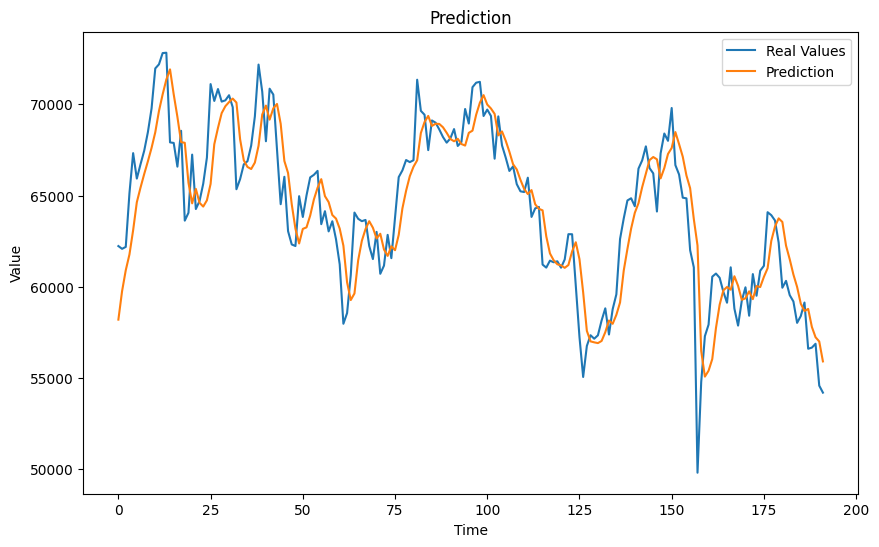

In [97]:
#Graph of the prediction
plt.figure(figsize=(10, 6))

df_reduced = df_testing['Open'].tolist()
#df_reduced = df_testing.iloc[60:][:]

plt.plot(df_reduced[60:], label='Real Values')
plt.plot(prediction, label='Prediction')

#Customize the graph
plt.title('Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()



